In [1]:
%env CUDA_VISIBLE_DEVICES=2
from pathlib import Path

if not Path("./small_fastmri_pd_3t").is_dir():
    !gdown --id "1y78Ad6WwQpMGtxfEZlp97A0iV98kAiJN"
    !unzip -q small_fastmri_pd_3t.zip && rm small_fastmri_pd_3t.zip
    
if not Path("./unet16-noiseless.pth").is_file():
    !gdown --id "1vBB8AqD_KJAnaf5vJpYNWNq02KWtoW2O"

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import sys
import numpy as np
import h5py
import pylab as plt
import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from k_space_reconstruction.nets.cdn import UnetDCAFModule, CascadeModule
from k_space_reconstruction.datasets.fastmri import FastMRITransform, FastMRIh5Dataset, RandomMaskFunc
from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim, ssim, nmse, psnr
from k_space_reconstruction.utils.loss import l1_loss, compund_mssim_l1_loss
from k_space_reconstruction.utils.kspace import spatial2kspace, kspace2spatial

# Dataset initialization

In [3]:
torch.manual_seed(42)
np.random.seed(42)


transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=1000,
    noise_type='none'
)

train_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/train.h5', transform)
val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=1, num_workers=12, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

# Model definition
plus, we load weight of trained unet

In [4]:
model_kwargs = dict(
    unet_chans=16, 
    unet_num_layers=4, 
    criterion=compund_mssim_l1_loss, 
    verbose_batch=50, 
    optimizer='RMSprop',
    lr=3e-4,
    lr_step_size=2,
    lr_gamma=0.9,
    weight_decay=0.0
)

cascade = CascadeModule(net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net]), **model_kwargs)
cascade.net[0].cascade[0].load_state_dict(torch.load('unet16-noiseless.pth'))

<All keys matched successfully>

In [5]:
def get_trainer():
    return pl.Trainer(
        gpus=1, max_epochs=5,
        accumulate_grad_batches=32,
        terminate_on_nan=True,
        default_root_dir='logs/CascadeUNetAF',
        callbacks=[
            pl.callbacks.ModelCheckpoint(
                save_last=True,
                save_top_k=7, 
                monitor='val_loss', 
                filename='{epoch}-{ssim:.4f}-{psnr:.4f}-{nmse:.5f}'
            ),
            pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
            pl.callbacks.GPUStatsMonitor(temperature=True)
        ]
    )

# Tensorboard logging

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/ --port 8001

# Cascade trainig
We sequentionaly train block (Unet + DC), freeze theese layers and append new block N times

In [ ]:
num_blocks = 5
for i in range(num_blocks):
    # Train cascade block
    trainer = get_trainer()
    trainer.fit(cascade, train_dataloader=train_generator, val_dataloaders=val_generator)
    # Freeze last cascade blocks
    for param in cascade.net.parameters():
        param.requires_grad = False
    # Add new block to cascade
    if i != num_blocks - 1:
        cascade = CascadeModule(net=cascade.net.append(UnetDCAFModule(**model_kwargs).net), **model_kwargs)
        # Load statedict for unet in last trainable block
        cascade.net[-1].cascade[0].load_state_dict(torch.load('unet16-noiseless.pth'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type                 | Params
----------------------------------------------------------
0 | NMSE             | DistributedMetricSum | 0     
1 | SSIM             | DistributedMetricSum | 0     
2 | PSNR             | DistributedMetricSum | 0     
3 | ValLoss          | DistributedMetricSum | 0     
4 | TotExamples      | DistributedMetricSum | 0     
5 | TotSliceExamples | DistributedMetricSum | 0     
6 | net              | ModuleList           | 2.8 M 


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# Cascade finetuning
Train one epoch all layers in cascade

In [ ]:
cascade = CascadeModule\
.load_from_checkpoint('logs/CascadeUNetAF/lightning_logs/version_4/checkpoints/last.ckpt', 
                      net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]))

trainer = pl.Trainer(
    gpus=1, max_epochs=20,
    accumulate_grad_batches=32,
    terminate_on_nan=True,
    default_root_dir='logs/CascadeUNetAF',
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            save_last=True,
            save_top_k=7, 
            monitor='val_loss', 
            filename='{epoch}-{ssim:.4f}-{psnr:.4f}-{nmse:.5f}'
        ),
        pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
        pl.callbacks.GPUStatsMonitor(temperature=True)
    ]
)
for param in cascade.net.parameters():
    param.requires_grad = True
trainer.fit(cascade, train_dataloader=train_generator, val_dataloaders=val_generator)

# Test model
Load best checkpoint, inference on val dataset and save predictions to .h5 file in logs directory

In [9]:
net = CascadeModule\
.load_from_checkpoint('logs/CascadeUNetAF/lightning_logs/version_5/checkpoints/last.ckpt', 
                      net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]))\
.eval()

In [10]:
trainer = get_trainer()
trainer.test(net, val_generator)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

# Val metrics

In [11]:
hf_pred = h5py.File('logs/CascadeUNetAF/2021-05-24 12:21:46.360073.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.8419961247666875, 0.007191214219533161, 33.34397692929986)

# Save state_dict

In [12]:
torch.save(net.net.state_dict(), 'cascade-x5-unet16-dcaf-noiseless.pth')

### Gaussian Noise

In [6]:
trainer = get_trainer()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


In [7]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=100,
    noise_type='normal'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

cascade = CascadeModule(net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]), **model_kwargs).eval()
cascade.net.load_state_dict(torch.load('cascade-x5-unet16-dcaf-gaussian.pth'))

trainer.test(cascade, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [8]:
hf_pred = h5py.File('logs/CascadeUNetAF/2021-05-25 10:17:52.973009.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.7254533753734163, 0.012516046321368688, 30.964159469737787)

In [6]:
cascade = CascadeModule(net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]), **model_kwargs).eval()
cascade.net.load_state_dict(torch.load('cascade-x5-unet16-dcaf-gaussian.pth'))

<All keys matched successfully>

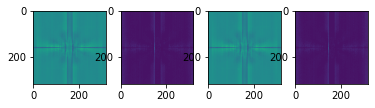

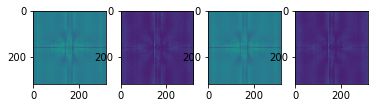

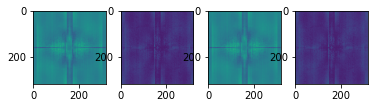

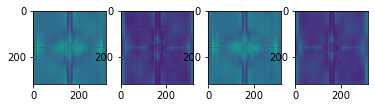

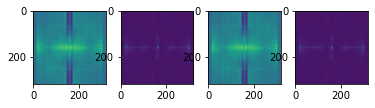

In [8]:
for i in range(5):
    fig, ax = plt.subplots(ncols=4)
    ax[0].imshow(cascade.net[i].cascade[1].al2.w_1[0].detach().cpu())
    ax[1].imshow(cascade.net[i].cascade[1].al2.b_1[0].detach().cpu())
    ax[2].imshow(cascade.net[i].cascade[1].al2.w_2[0].detach().cpu())
    ax[3].imshow(cascade.net[i].cascade[1].al2.b_2[0].detach().cpu())
    plt.show()

### Salt&Pepper Noise

In [9]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=5e4,
    noise_type='salt'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

cascade = CascadeModule(net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]), **model_kwargs).eval()
cascade.net.load_state_dict(torch.load('cascade-x5-unet16-dcaf-salt.pth'))

trainer.test(cascade, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [10]:
hf_pred = h5py.File('logs/CascadeUNetAF/2021-05-25 10:18:40.623769.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.5208086136654744, 0.05841492540672835, 25.867625515488577)

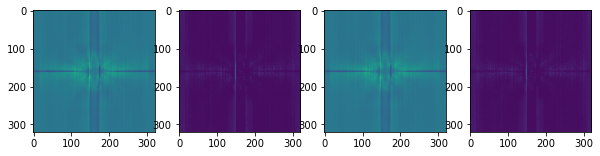

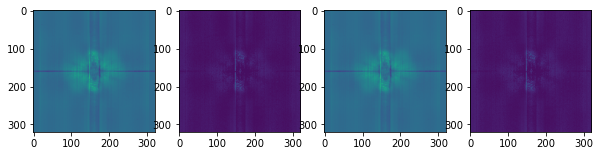

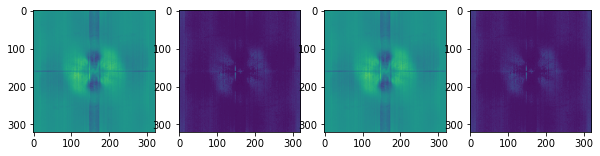

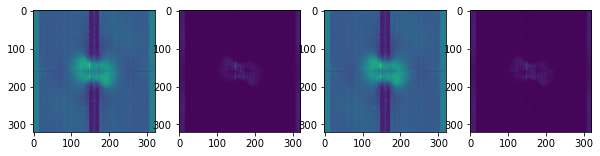

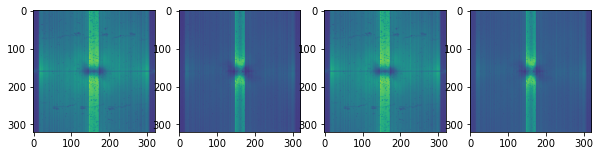

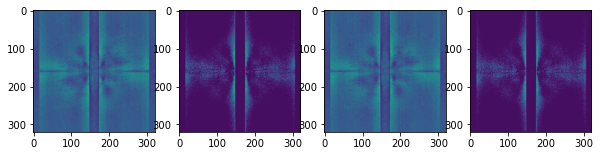

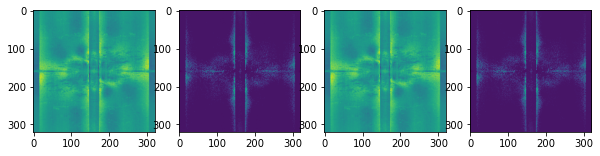

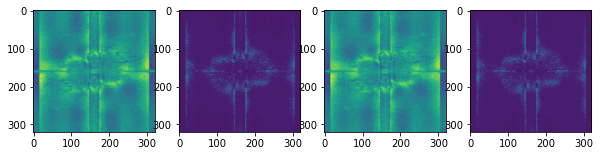

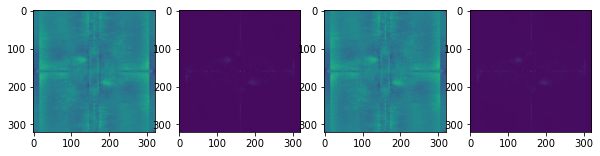

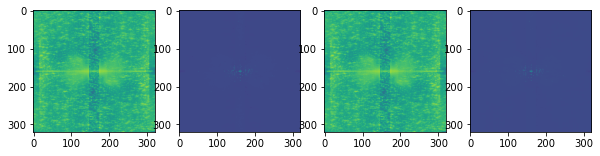

In [11]:
for i in range(5):
    fig, ax = plt.subplots(ncols=4, figsize=(10,5))
    ax[0].imshow(cascade.net[i].cascade[1].al2.w_1[0].detach().cpu())
    ax[1].imshow(cascade.net[i].cascade[1].al2.b_1[0].detach().cpu())
    ax[2].imshow(cascade.net[i].cascade[1].al2.w_2[0].detach().cpu())
    ax[3].imshow(cascade.net[i].cascade[1].al2.b_2[0].detach().cpu())
    plt.show()
print('============================================================')
for i in range(5):
    fig, ax = plt.subplots(ncols=4, figsize=(10,5))
    ax[0].imshow(cascade.net[i].cascade[1].al1.w_1[0].detach().cpu())
    ax[1].imshow(cascade.net[i].cascade[1].al1.b_1[0].detach().cpu())
    ax[2].imshow(cascade.net[i].cascade[1].al1.w_2[0].detach().cpu())
    ax[3].imshow(cascade.net[i].cascade[1].al1.b_2[0].detach().cpu())
    plt.show()

### Gaussian + Salt&Pepper Noise

In [11]:
torch.manual_seed(42)
np.random.seed(42)

transform = FastMRITransform(
    RandomMaskFunc([0.08], [4]),
    noise_level=5e4,
    noise_type='normal_and_salt'
)

val_dataset = FastMRIh5Dataset('small_fastmri_pd_3t/val.h5', transform)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, num_workers=12)

cascade = CascadeModule(net=torch.nn.ModuleList([UnetDCAFModule(**model_kwargs).net for _ in range(5)]), **model_kwargs).eval()
cascade.net.load_state_dict(torch.load('cascade-x5-unet16-dcaf-normal-and-salt.pth'))

trainer.test(cascade, val_generator)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------


1

In [12]:
hf_pred = h5py.File('logs/CascadeUNetAF/2021-05-25 10:19:23.897475.h5')
hf_gt = h5py.File('small_fastmri_pd_3t/val.h5')

ssim_vals = []
nmse_vals = []
psnr_vals = []
for k in hf_pred.keys():
    ks = hf_gt[k][:] * 1e6
    gt = np.stack([kspace2spatial(k) for k in ks])
    pred = hf_pred[k][:,0]
    ssim_vals.append(ssim(gt, pred))
    nmse_vals.append(nmse(gt, pred))
    psnr_vals.append(psnr(gt, pred))
ssim_vals = np.array(ssim_vals)
nmse_vals = np.array(nmse_vals)
psnr_vals = np.array(psnr_vals)

np.mean(ssim_vals), np.mean(nmse_vals), np.mean(psnr_vals)

(0.5130549507697368, 0.051732053618718646, 25.866922708921713)